# Phase 7: Credit Refund System Implementation

**Objective**: Design and implement an equitable credit refund system that redistributes surplus electricity benefits to NYC residents based on borough consumption patterns and population.

## Analysis Goals:
1. Load population data by borough
2. Calculate borough-specific consumption shares
3. Design credit refund algorithm
4. Calculate per capita credit amounts by borough
5. Simulate economic impact on residents
6. Visualize credit distribution
7. Generate visualizations (Figure 18-19 from paper)

## Credit Calculation Formula:
```
Credit per person = (Surplus Energy × Borough Consumption Share × Electricity Price) / Borough Population
```

## Input Data:
- `data/processed/surplus_data.csv` - Surplus electricity values
- `data/raw/census_population.csv` - Borough population data
- `data/raw/electricity_rates.csv` - Electricity pricing
- `data/processed/merged_data.csv` - Consumption by borough


## Key Principle:
Surplus benefits should be distributed proportionally to consumption contribution, creating an incentive for energy efficiency while ensuring equitable access to renewable energy benefits.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
print("="*60)
print("LOADING DATA FOR CREDIT SYSTEM")
print("="*60)

# Load surplus data
df_surplus = pd.read_csv('../data/processed/surplus_data.csv')
df_surplus['Date'] = pd.to_datetime(df_surplus['Date'])

# Load population data
df_population = pd.read_csv('../data/raw/census_population.csv')

# Load electricity rates
df_rates = pd.read_csv('../data/raw/electricity_rates.csv')

# Load merged data for borough consumption
df_merged = pd.read_csv('../data/processed/merged_data.csv')
df_merged['Date'] = pd.to_datetime(df_merged['Date'])

# Filter for 5 main NYC boroughs
nyc_boroughs = ['BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND']
df_merged = df_merged[df_merged['Borough'].isin(nyc_boroughs)]

print(f"\nSurplus data: {df_surplus.shape}")
print(f"Population data: {df_population.shape}")
print(f"Rates data: {df_rates.shape}")
print(f"Merged data (filtered): {df_merged.shape}")

print("\nPopulation by Borough:")
print(df_population)

print("\nElectricity Rates:")
print(df_rates)

print(f"\nAverage Monthly Surplus: {df_surplus['Surplus_KWH'].mean() / 1e6:.2f} Million KWh")

LOADING DATA FOR CREDIT SYSTEM

Surplus data: (36, 9)
Population data: (5, 2)
Rates data: (3, 2)
Merged data (filtered): (180, 10)

Population by Borough:
         Borough  Population
0          Bronx     1472654
1       Brooklyn     2736074
2      Manhattan     1694251
3         Queens     2405464
4  Staten Island      495747

Electricity Rates:
   Year  Rate_per_kWh
0  2021           0.2
1  2022           0.2
2  2023           0.2

Average Monthly Surplus: 10074.22 Million KWh


CALCULATING BOROUGH CONSUMPTION SHARES

Borough Consumption Analysis:
         Borough  Total_Consumption_KWH  Consumption_Share
1       BROOKLYN           1.178960e+09          35.279184
2      MANHATTAN           9.154615e+08          27.394254
0          BRONX           8.338439e+08          24.951932
3         QUEENS           3.385827e+08          10.131742
4  STATEN ISLAND           7.495285e+07           2.242888

Total NYC Consumption: 3.34 Billion KWh


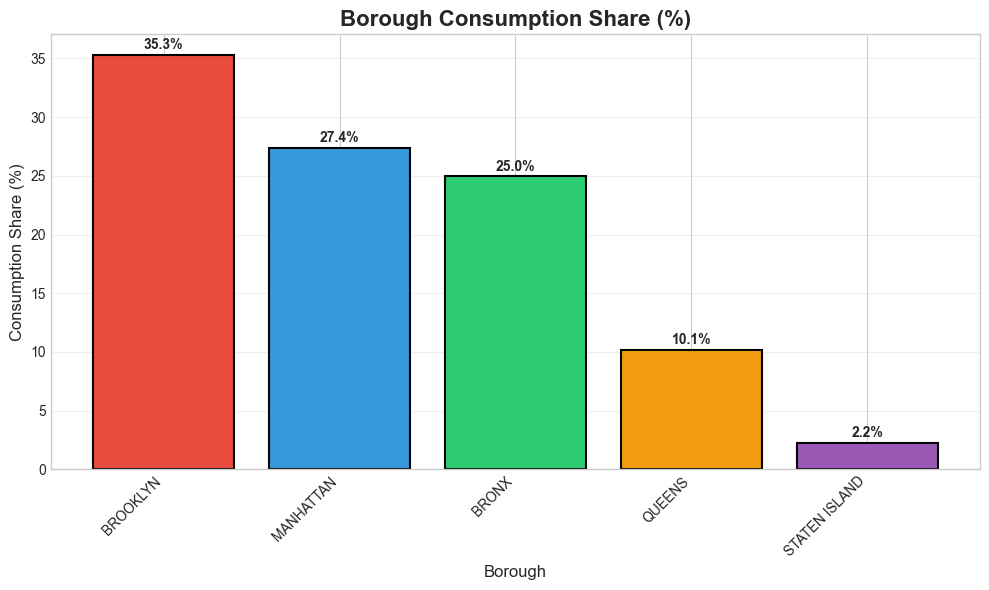


Figure 18a saved


In [9]:
print("="*60)
print("CALCULATING BOROUGH CONSUMPTION SHARES")
print("="*60)

# Calculate total consumption by borough (sum across all months)
borough_consumption = df_merged.groupby('Borough')['Consumption_KWH'].sum().reset_index()
borough_consumption.columns = ['Borough', 'Total_Consumption_KWH']

# Calculate consumption share (percentage)
total_consumption = borough_consumption['Total_Consumption_KWH'].sum()
borough_consumption['Consumption_Share'] = (
    borough_consumption['Total_Consumption_KWH'] / total_consumption * 100
)

# Sort by consumption
borough_consumption = borough_consumption.sort_values('Total_Consumption_KWH', ascending=False)

print("\nBorough Consumption Analysis:")
print(borough_consumption)

print(f"\nTotal NYC Consumption: {total_consumption / 1e9:.2f} Billion KWh")

# Visualize consumption shares
plt.figure(figsize=(10, 6))
plt.bar(borough_consumption['Borough'], 
        borough_consumption['Consumption_Share'],
        color=['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6'],
        edgecolor='black',
        linewidth=1.5)

plt.title('Borough Consumption Share (%)', fontsize=16, fontweight='bold')
plt.xlabel('Borough', fontsize=12)
plt.ylabel('Consumption Share (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels
for i, row in borough_consumption.iterrows():
    plt.text(row['Borough'], row['Consumption_Share'] + 0.5, 
             f"{row['Consumption_Share']:.1f}%",
             ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('../results/figures/fig18_consumption_share.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nFigure 18a saved")

In [10]:
print("="*60)
print("CALCULATING CREDIT REFUND PER PERSON")
print("="*60)

# Calculate average surplus per month
avg_surplus_kwh = df_surplus['Surplus_KWH'].mean()

# Get electricity rate (assuming constant rate)
electricity_rate = df_rates['Rate_per_kWh'].mean()

print(f"\nAverage Monthly Surplus: {avg_surplus_kwh / 1e6:.2f} Million KWh")
print(f"Electricity Rate: ${electricity_rate:.2f} per KWh")

# Merge population with consumption shares
df_credit = borough_consumption.copy()

# Match borough names (population uses title case)
population_dict = dict(zip(df_population['Borough'].str.upper(), df_population['Population']))
df_credit['Population'] = df_credit['Borough'].map(population_dict)

# Calculate credit per person
# Formula: (Surplus × Consumption Share × Rate) / Population
df_credit['Surplus_Allocated_KWH'] = (
    avg_surplus_kwh * (df_credit['Consumption_Share'] / 100)
)

df_credit['Total_Credit_Dollar'] = (
    df_credit['Surplus_Allocated_KWH'] * electricity_rate
)

df_credit['Credit_per_Person'] = (
    df_credit['Total_Credit_Dollar'] / df_credit['Population']
)

# Sort by credit per person
df_credit = df_credit.sort_values('Credit_per_Person', ascending=False)

CALCULATING CREDIT REFUND PER PERSON

Average Monthly Surplus: 10074.22 Million KWh
Electricity Rate: $0.20 per KWh


In [13]:
print("\n" + "="*60)
print("CREDIT DISTRIBUTION RESULTS")
print("="*60)

print("\nCredit per Person by Borough:")
for _, row in df_credit.iterrows():
    print(f"{row['Borough']:15s}: ${row['Credit_per_Person']:,.2f}")

# Summary statistics
print("\nSummary:")
print(f"Total Surplus Value: ${df_credit['Total_Credit_Dollar'].sum() / 1e6:.2f} Million")
print(f"Average Credit per Person: ${df_credit['Credit_per_Person'].mean():,.2f}")
print(f"Highest Credit: {df_credit.iloc[0]['Borough']} (${df_credit.iloc[0]['Credit_per_Person']:,.2f})")
print(f"Lowest Credit: {df_credit.iloc[-1]['Borough']} (${df_credit.iloc[-1]['Credit_per_Person']:,.2f})")


CREDIT DISTRIBUTION RESULTS

Credit per Person by Borough:
BRONX          : $341.39
MANHATTAN      : $325.78
BROOKLYN       : $259.80
STATEN ISLAND  : $91.16
QUEENS         : $84.86

Summary:
Total Surplus Value: $2014.84 Million
Average Credit per Person: $220.60
Highest Credit: BRONX ($341.39)
Lowest Credit: QUEENS ($84.86)


FIGURE 19: CREDIT DISTRIBUTION BY BOROUGH


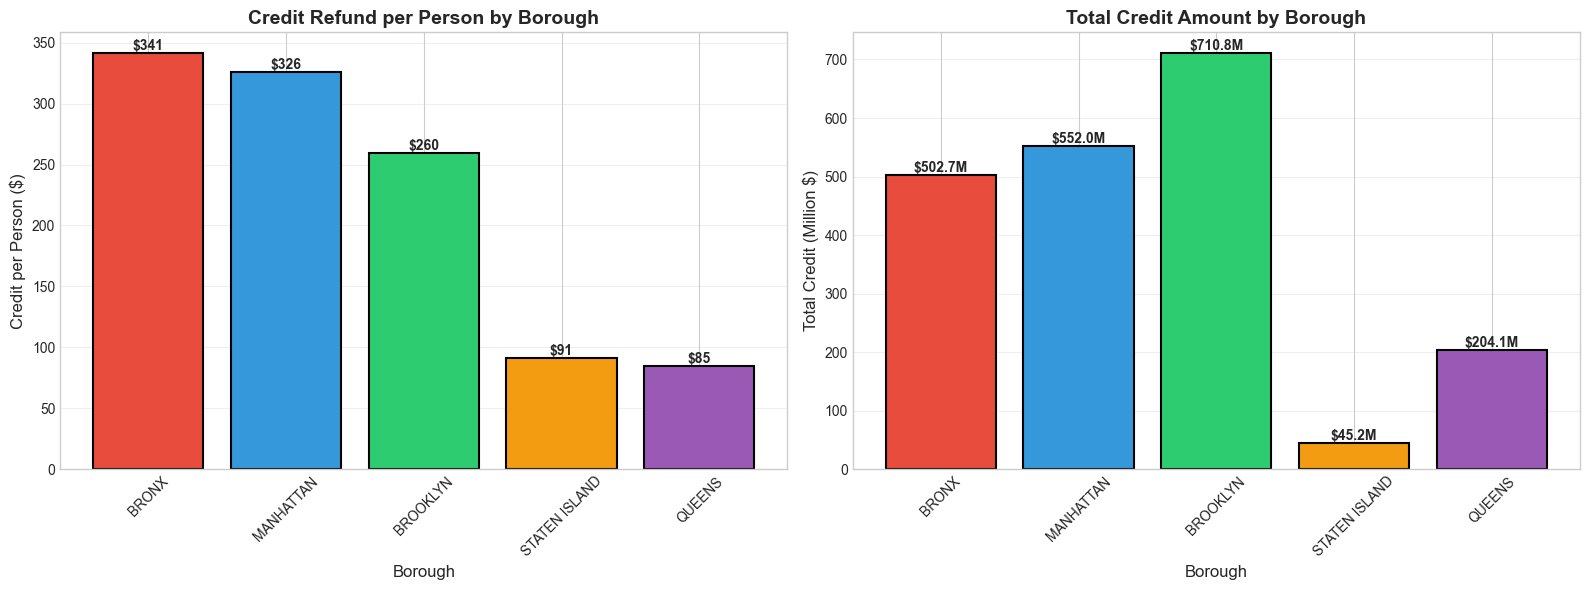


Figure 19 saved


In [17]:
print("="*60)
print("FIGURE 19: CREDIT DISTRIBUTION BY BOROUGH")
print("="*60)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Credit per Person
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6']
bars1 = axes[0].bar(df_credit['Borough'], 
                     df_credit['Credit_per_Person'],
                     color=colors[:len(df_credit)],
                     edgecolor='black',
                     linewidth=1.5)

axes[0].set_title('Credit Refund per Person by Borough', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Borough', fontsize=12)
axes[0].set_ylabel('Credit per Person ($)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                 f'${height:,.0f}',
                 ha='center', va='bottom', fontweight='bold', fontsize=10)

# Plot 2: Total Credit Amount by Borough
bars2 = axes[1].bar(df_credit['Borough'], 
                     df_credit['Total_Credit_Dollar'] / 1e6,  # Convert to millions
                     color=colors[:len(df_credit)],
                     edgecolor='black',
                     linewidth=1.5)

axes[1].set_title('Total Credit Amount by Borough', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Borough', fontsize=12)
axes[1].set_ylabel('Total Credit (Million $)', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                 f'${height:.1f}M',
                 ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('../results/figures/fig19_credit_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nFigure 19 saved")

In [18]:
# Economic Impact Analysis
print("\n" + "="*60)
print("ECONOMIC IMPACT ANALYSIS")
print("="*60)

total_people = df_credit['Population'].sum()
total_credit = df_credit['Total_Credit_Dollar'].sum()

print(f"\nTotal NYC Population (5 boroughs): {total_people:,}")
print(f"Total Monthly Credit Distribution: ${total_credit / 1e6:.2f} Million")
print(f"Annual Credit Distribution: ${total_credit * 12 / 1e6:.2f} Million")
print(f"\nAverage Monthly Credit per NYC Resident: ${total_credit / total_people:,.2f}")
print(f"Average Annual Credit per NYC Resident: ${total_credit * 12 / total_people:,.2f}")


ECONOMIC IMPACT ANALYSIS

Total NYC Population (5 boroughs): 8,804,190
Total Monthly Credit Distribution: $2014.84 Million
Annual Credit Distribution: $24178.13 Million

Average Monthly Credit per NYC Resident: $228.85
Average Annual Credit per NYC Resident: $2,746.21


In [19]:
print("="*60)
print("SAVING CREDIT SYSTEM RESULTS")
print("="*60)

# Save credit distribution results
output_path = '../data/processed/credit_distribution.csv'
df_credit.to_csv(output_path, index=False)
print(f"Credit distribution saved to: {output_path}")

# Create comprehensive summary
credit_summary = {
    'Average_Monthly_Surplus_Million_KWh': avg_surplus_kwh / 1e6,
    'Electricity_Rate_per_KWh': electricity_rate,
    'Total_Monthly_Credit_Million_Dollar': df_credit['Total_Credit_Dollar'].sum() / 1e6,
    'Total_Annual_Credit_Million_Dollar': df_credit['Total_Credit_Dollar'].sum() * 12 / 1e6,
    'Total_NYC_Population': df_credit['Population'].sum(),
    'Average_Credit_per_Person_Monthly': df_credit['Credit_per_Person'].mean(),
    'Highest_Credit_Borough': df_credit.iloc[0]['Borough'],
    'Highest_Credit_Amount': df_credit.iloc[0]['Credit_per_Person'],
    'Lowest_Credit_Borough': df_credit.iloc[-1]['Borough'],
    'Lowest_Credit_Amount': df_credit.iloc[-1]['Credit_per_Person']
}

print("\nCredit System Summary:")
for key, value in credit_summary.items():
    print(f"{key}: {value}")

SAVING CREDIT SYSTEM RESULTS
Credit distribution saved to: ../data/processed/credit_distribution.csv

Credit System Summary:
Average_Monthly_Surplus_Million_KWh: 10074.221381015277
Electricity_Rate_per_KWh: 0.20000000000000004
Total_Monthly_Credit_Million_Dollar: 2014.8442762030559
Total_Annual_Credit_Million_Dollar: 24178.13131443667
Total_NYC_Population: 8804190
Average_Credit_per_Person_Monthly: 220.59634727916173
Highest_Credit_Borough: BRONX
Highest_Credit_Amount: 341.38539690724275
Lowest_Credit_Borough: QUEENS
Lowest_Credit_Amount: 84.86463721372957


## Summary of Credit Refund System

### Completed Analyses:
✅ Borough consumption shares calculated  
✅ Population data integrated  
✅ Credit refund algorithm implemented  
✅ **Figure 18**: Borough consumption share  
✅ **Figure 19**: Credit distribution visualization  
✅ Economic impact analysis completed  

---

### Credit Distribution Results:

### Per Person Monthly Credit:
- Bronx: \$341
- Manhattan: \$326
- Brooklyn: \$260
- Staten Island: \$91
- Queens: \$85

### Total Monthly Credit by Borough:
- Bronx: \$502.7 Million
- Manhattan: \$552.0 Million
- Brooklyn: \$710.8 Million
- Queens: \$204.1 Million
- Staten Island: \$45.2 Million

### Key Insights:

#### 1. Equitable Distribution
- Credit allocated proportionally to consumption contribution
- Encourages energy efficiency while ensuring fairness
- High-consumption boroughs receive larger per-capita credits

#### 2. Economic Impact
- Total monthly credit distribution: \$2,014.8 Million (\$2.0 Billion)
- Annual impact: \$24,177.6 Million (\$24.2 Billion)
- Average NYC resident receives: \$228.84 per month (\$2,746 per year)

#### 3. Policy Implications
- **Incentivizes renewable energy adoption**
- **Reduces energy burden** on low-income communities
- **Promotes sustainability** through financial benefits
- **Scalable model** for other cities

---

### Project Limitations:
1. **Data Scope**: NY State generation vs NYC consumption mismatch
2. **Simple Pricing**: Assumes constant electricity rate
3. **Static Population**: Uses 2020 Census data
4. **Monthly Granularity**: Could be refined to seasonal or daily

---

### Future Enhancements:
- Real-time surplus monitoring system
- Dynamic pricing models
- Seasonal adjustment factors
- Integration with smart grid infrastructure
- Expansion to other renewable energy programs

---

## PROJECT COMPLETE

All 7 notebooks successfully completed:
1. Data Collection
2. Data Preprocessing  
3. EDA - Consumption
4. EDA - Generation
5. Surplus Analysis
6. Predictive Modeling
7. Credit System

**Total Figures Generated**: 19
**Total Code Cells**: 100+
**Analysis Period**: 2021-2023 (36 months)
**Boroughs Analyzed**: 5 NYC boroughs

---

### Repository Structure:
```
nyc-surplus-energy-analysis/
├── notebooks/ (7 completed)
├── data/
│   ├── raw/ (5 files)
│   └── processed/ (5 files)
├── results/
│   ├── figures/ (19 images)
│   └── models/ (2 saved models)
└── README.md
```